In [1]:
import matplotlib.pyplot as plt
import geopandas as gpd
import pandas as pd
import numpy as np
from info import info
from sklearn.linear_model import LinearRegression
import os

In [2]:
cocs = {
    "LG18P":"LG18P_BARN",
    "GOV18P":"GOV18P_MIT",
    "SOS18P":"SOS18P_MAR",
    "PRES20":"PRES20D",
    "GOV18":"GOV18D",
    "SOS18":"SOS18D",
    "TRE18":"TRES18D",
    "AG18":"AG18D",
    "SEN18":"SEN18D",
    "PRES16":"PRES16D",
    "SEN16":"SEN16D",
    "GOV14":"GOV14D",
    "SOS14":"SOS14D",
    "TRE14":"TRES14D",
    "AG14":"AG14D",
    "PRES12":"PRES12D",
    "SEN12":"SEN12D",
}

In [31]:
info["WI_20"]

{'shapefile_path': 'shapes/WI_DATA_20.csv',
 'MATCH_KEY': 'NAME',
 'COUNTY_COL': 'COUNTYFP',
 'counties': [None],
 'elections': {'LG18P': {'POP_COL': 'VAP',
   'candidates': {'LG18P_BARN': {'name': 'Mandela Barnes',
     'race': 'B',
     'won': True},
    'LG18P_KOBE': {'name': 'Kurt Kober', 'race': 'W', 'won': False}}},
  'GOV18P': {'POP_COL': 'VAP',
   'candidates': {'GOV18P_EVE': {'name': 'Tony Evers',
     'race': 'W',
     'won': True},
    'GOV18P_MIT': {'name': 'Mahlon Mitchell', 'race': 'B', 'won': False}}},
  'SOS18P': {'POP_COL': 'VAP',
   'candidates': {'SOS18P_LAF': {'name': 'Douglas LaFollette',
     'race': 'W',
     'won': True},
    'SOS18P_MAR': {'name': 'Arvina Martin', 'race': 'AMIN', 'won': False}}},
  'PRES20': {'POP_COL': 'VAP',
   'candidates': {'PRES20D': {'name': 'Joe Biden', 'race': 'W', 'won': True},
    'PRES20R': {'name': 'Donald Trump', 'race': 'W', 'won': False}}},
  'GOV18': {'POP_COL': 'VAP',
   'candidates': {'GOV18D': {'name': 'Tony Evers', 'race': '

In [18]:
gdf = gpd.read_file("shapes/WI_vtd20/")
df = gpd.read_file("shapes/WI_DATA_20.csv")

In [78]:
def plot_scatter(df, election):
    candidates = list(info["WI_20"]["elections"][election]["candidates"].keys())
    df[candidates] = df[candidates].apply(pd.to_numeric)
#     df = df.dropna()
    df = df[df[candidates].sum(axis=1) > 0]
    coc_pct = df[cocs[election]] / df[candidates].sum(axis=1)
    if "VAP" in df.columns:
        df["WVAP"] = pd.to_numeric(df["WVAP"])
        df["VAP"] = pd.to_numeric(df["VAP"])
        wvap_pct = df["WVAP"] / df["VAP"]
    else:
        wvap_pct = df["WVAP20"] / df["VAP20"]
    coc_last_name = info["WI_20"]["elections"][election]["candidates"][cocs[election]]["name"].split(" ")[-1]

    fig, ax = plt.subplots(figsize=(8,8))
    plt.scatter(coc_pct, wvap_pct)
    return

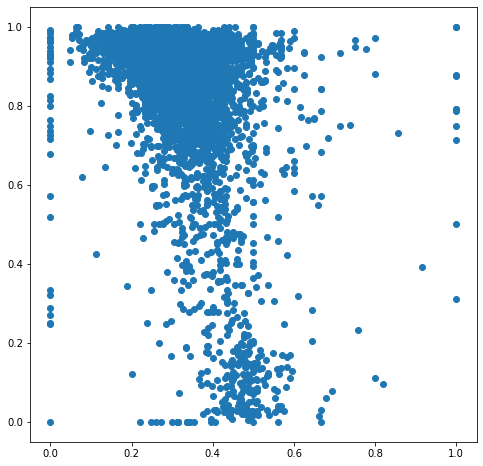

In [83]:
plot_scatter(df, "SOS18P")

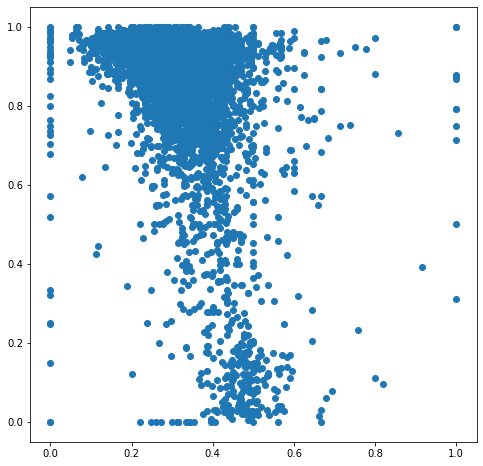

In [84]:
plot_scatter(gdf, "SOS18P")

(array([2610., 2963.,  810.,  431.,  150.,   59.,   18.,   10.,    5.,
           3.]),
 array([   0. ,  369.2,  738.4, 1107.6, 1476.8, 1846. , 2215.2, 2584.4,
        2953.6, 3322.8, 3692. ]),
 <BarContainer object of 10 artists>)

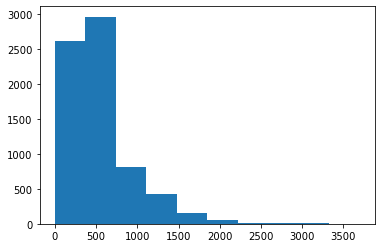

In [28]:
plt.hist(gdf["WVAP20"])

(array([2560., 2957.,  808.,  431.,  151.,   59.,   18.,   10.,    5.,
           3.]),
 array([   0. ,  369.2,  738.4, 1107.6, 1476.8, 1846. , 2215.2, 2584.4,
        2953.6, 3322.8, 3692. ]),
 <BarContainer object of 10 artists>)

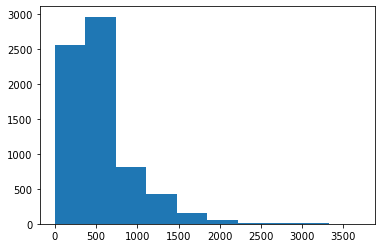

In [29]:
plt.hist(pd.to_numeric(df["WVAP"]))

In [15]:
gdf["LG18P_BARN"].sum()

326423.0

In [24]:
pd.to_numeric(df["LG18P_BARN"]).sum()

326423.0

In [12]:
barnes_pct = gdf["LG18P_BARN"] / gdf[["LG18P_BARN", "LG18P_KOBE"]].sum(axis=1)
mitchell_pct = gdf["GOV18P_MIT"] / gdf[["GOV18P_MIT", "GOV18P_EVE"]].sum(axis=1)
wvap_pct = gdf["WVAP20"] / gdf["VAP20"]

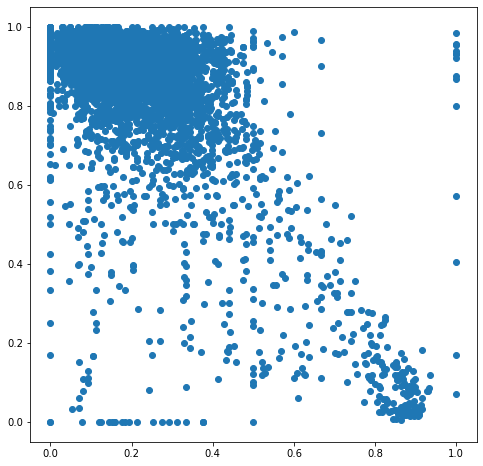

In [13]:
fig, ax = plt.subplots(figsize=(8,8))
plt.scatter(mitchell_pct,
            wvap_pct)

In [122]:
def best_fit_mb(xs, ys):
    m = (((np.mean(xs)*np.mean(ys)) - np.mean(xs*ys)) /
         ((np.mean(xs)*np.mean(xs)) - np.mean(xs*xs)))
    b = np.mean(ys) - m*np.mean(xs)
    return m, b

def get_data(df, state, election, cocs=cocs):
    os.makedirs("WI_ER_201321", exist_ok=True)
    candidates = list(info[state]["elections"][election]["candidates"].keys())
    df = df.dropna()
    df = df[df[candidates].sum(axis=1) > 0]
    coc_pct = df[cocs[election]] / df[candidates].sum(axis=1)
    wvap_pct = df["WVAP"] / df["VAP"]
    coc_last_name = info[state]["elections"][election]["candidates"][cocs[election]]["name"].split(" ")[-1]
    
    m, b = best_fit_mb(wvap_pct, coc_pct)
    unweighted_xs = np.arange(0, 1, 0.01)
    unweighted_ys = [m*x + b for x in unweighted_xs]
    
    x = np.reshape(wvap_pct.values, (len(df), 1))
    y = np.reshape(coc_pct.values, (len(df), 1))
    line = LinearRegression().fit(x, y, (df[candidates].sum(axis=1)))
#     line = LinearRegression().fit(x, y)
    weighted_xs = np.reshape(unweighted_xs, (len(unweighted_xs), 1))
    weighted_ys = line.predict(weighted_xs)
    
    _, ax = plt.subplots(figsize=(8,8))
    ax.scatter(wvap_pct,
               coc_pct,
               c=df[candidates].sum(axis=1),
               cmap='jet',
              )
    ax.plot(unweighted_xs,
            unweighted_ys,
            color="gray",
            label="unweighted",
            lw=2,
           )
    ax.plot(weighted_xs,
            weighted_ys,
            color="red",
            label="weighted",
            lw=2,
           )
    ax.set_xlabel("WVAP Share", fontsize=24)
    ax.set_ylabel(f"{coc_last_name} Share", fontsize=24)
    ax.legend()
#     ax.set_xlim(0,1)
#     ax.set_ylim(0,1)
    
    plt.savefig(f"WI_ER_201321/{state}_{election}_scatter.png", dpi=600, bbox_inches='tight')
    plt.show()
    plt.close()
    return coc_last_name, weighted_ys[0][0], weighted_ys[-1][0]

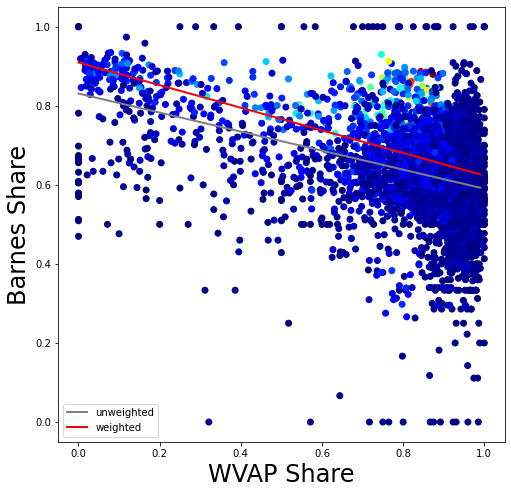

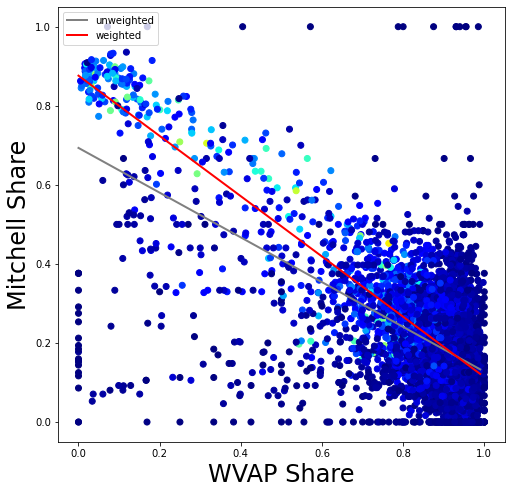

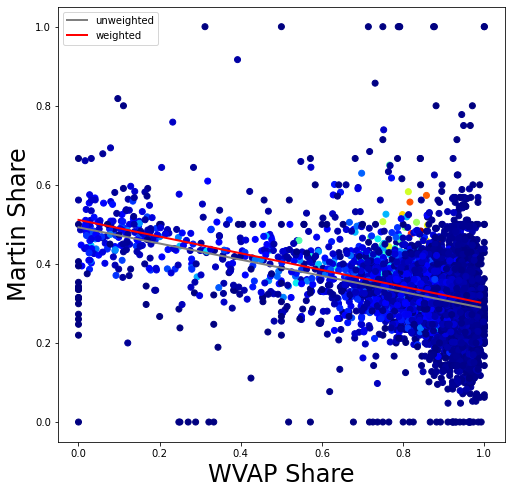

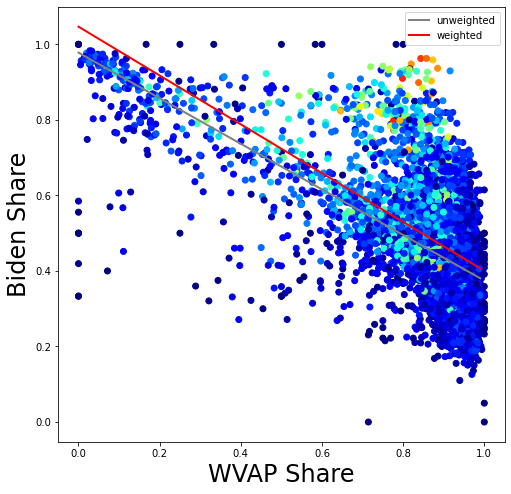

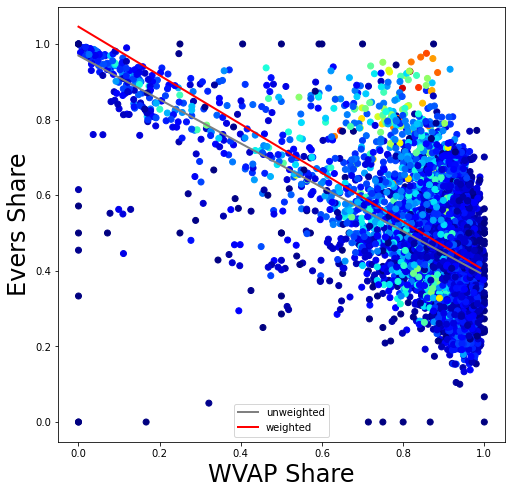

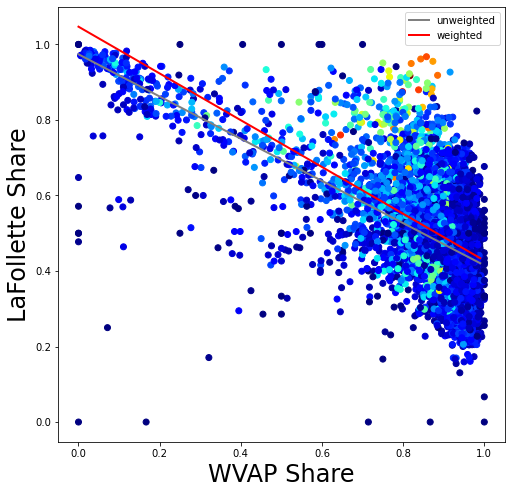

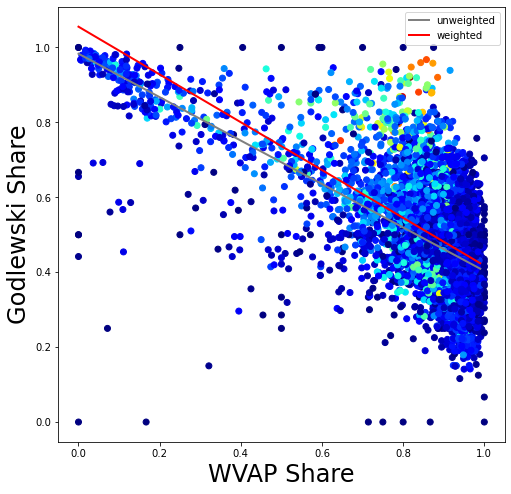

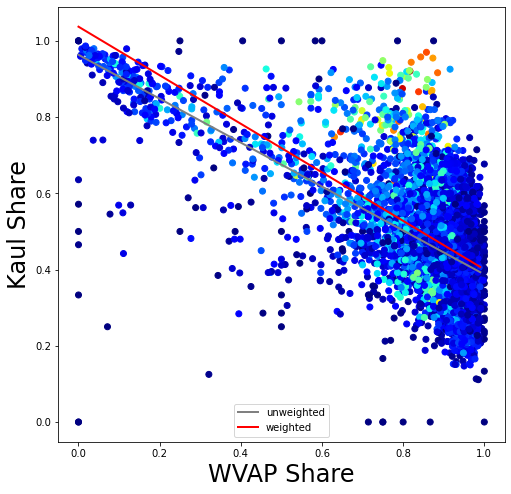

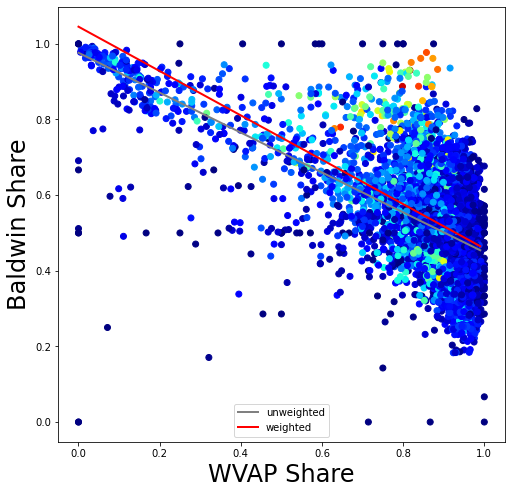

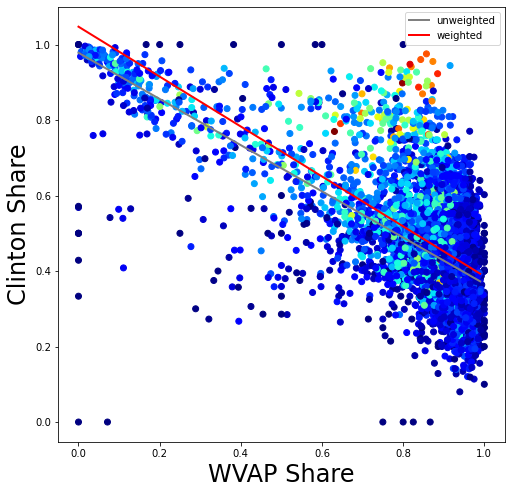

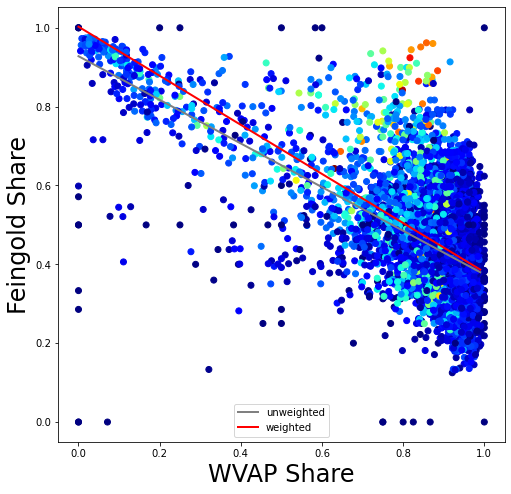

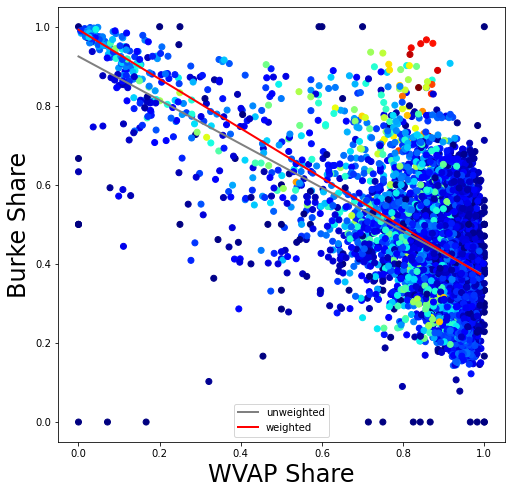

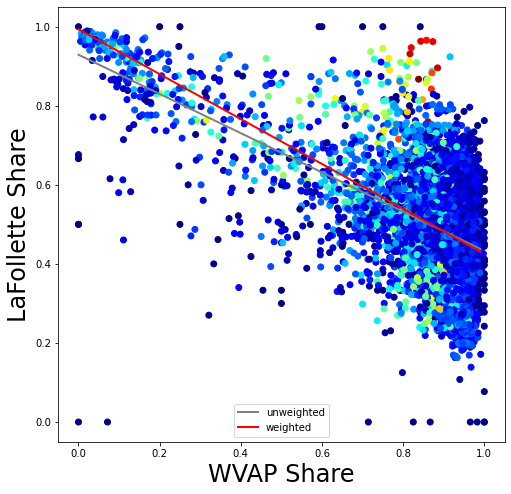

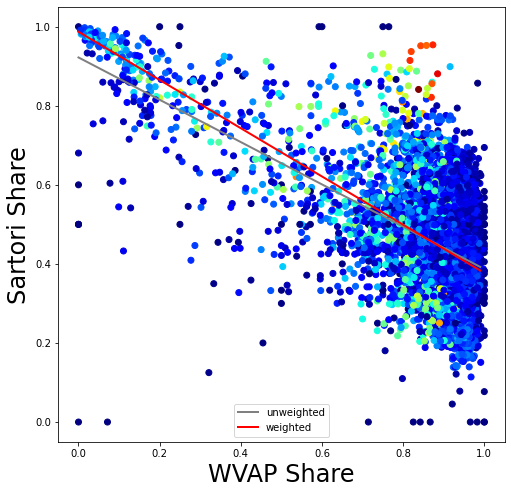

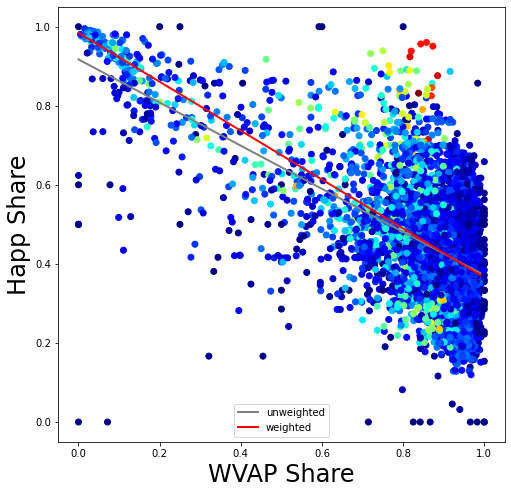

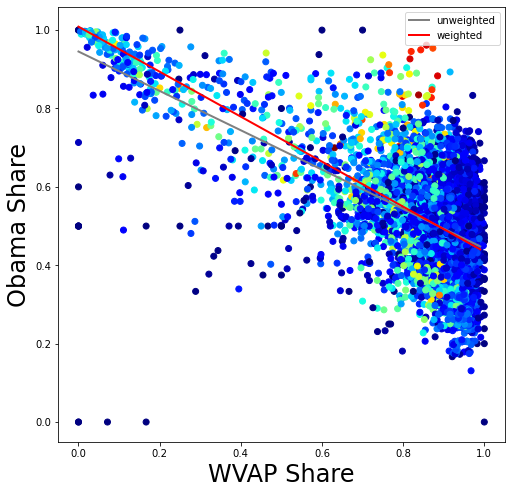

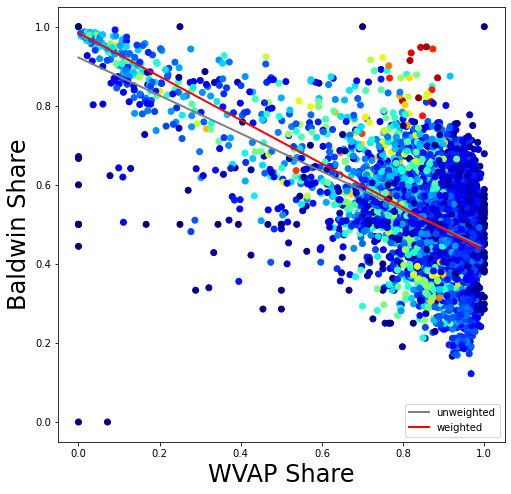

In [123]:
os.makedirs("WI_ER_201321", exist_ok=True)
with open("WI_ER_201321/ER_intercepts.csv", "w") as f:
    f.write("election,candidate,POC_support,White_support\n")
    for elec in cocs.keys():
        name, poc, white = get_data(df, "WI_20", elec)
        f.write(f"{elec},{name},{poc},{white}\n")
f.close()